# Simon Task fMRI – First-level GLM Analysis

## 1. Environment Setup
Import the necessary libraries for neuroimaging (Nilearn), data manipulation (Pandas, NumPy), and system operations.

In [8]:
# Import libraries
import os
import glob
import numpy as np
import pandas as pd

from nilearn import image, plotting
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix

## 2. Configuration
Define the dataset root directory, fMRI acquisition parameters (TR), and the runs to be analyzed.

In [11]:
# Configuration

# Base directory containing the BIDS-format dataset
base_path = "data/ds101_R2.0.0/"

# Repetition Time (TR) of the fMRI acquisition, in seconds
TR = 2.0
#The dataset contains two runs per subject
runs = [1, 2]

print("Todo cargó bien")

Todo cargó bien


## 3. Behavioral Data Inspection
Load and inspect the raw event files to understand the distribution of trial types and ensure data integrity across subjects.

In [ ]:
# Path to behavioral files inside the BIDS dataset
events_files = sorted(glob.glob(os.path.join(base_path, "sub-*", "func", "*_events.tsv")))

all_events = []

# Load all behavioral files and concatenate them
for f in events_files:
    df = pd.read_csv(f, sep="\t")
    subject = f.split("sub-")[1].split("/")[0]   # extract subject ID
    df["subject"] = subject
    all_events.append(df)

# Combine all subjects into one DataFrame
behaviour = pd.concat(all_events, ignore_index=True)

# Visualization

print("Shape of the behavioral dataset:", behaviour.shape)

print("\nTrials per congruency:")
print(behaviour["trial_type"].value_counts())

print("\nTrials per subject:")
print(behaviour["subject"].value_counts())

# Display first rows for inspection
behaviour.head()

## 4. Data Preparation Helpers
Set up output directories and define helper functions for processing trial types (congruency mapping).

In [14]:
# Create an output directory to store the resulting Z maps
output_dir = "first_level_results"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Function recode trial types
def map_congruency(tt):
    """
    Maps the original trial_type strings to either
    "congruent" or "incongruent" based on keyword matching.
    Any other type is discarded (returns None).
    """
    tt = str(tt).lower()
    if "incongruent" in tt:
        return "incongruent"
    elif "congruent" in tt:
        return "congruent"
    else:
        return None

In [ ]:
# List of subjects: sub-01 through sub-21
subjects = [f"sub-{i:02d}" for i in range(1, 22)]
for s in subjects:
    print(s)

## 5. Generate Master Behavioral Dataset
Process all subject event files to create a single, cleaned CSV file (`simon_behaviour_clean.csv`). This dataset includes:
- Subject and run information.
- Trial-level details.
- Recoded congruency and accuracy labels.
- Binary labels for machine learning (0 = Congruent, 1 = Incongruent).

In [ ]:
# Behavioral master DataFrame clean

# This cell:
#  - Reads all *_events.tsv files for all subjects
#  - Extracts subject, run, trial number
#  - Splits trial_type into congruency + accuracy
#  - Creates binary label (0 = congruent, 1 = incongruent)
#  - Selects only relevant behavioral variables
#  - Saves a clean CSV version of the dataset

import glob
import pandas as pd

# Pattern to find all event files for all subjects
pattern = os.path.join(base_path, "sub-*", "func", "*_events.tsv")
files = sorted(glob.glob(pattern))

print("Number of event files found:", len(files))

all_rows = []

for f in files:
    # Read events file
    df = pd.read_csv(f, sep="\t")
    
    # Extract subject and run from file path
    subject = f.split("/")[-3]      # e.g., "sub-01"
    run = f.split("/")[-1]          # full file name of the run
    
    df["subject"] = subject
    df["run"] = run
    
    # Continuous trial number within each run
    df["trial"] = range(1, len(df) + 1)
    
    # Extract congruency and accuracy from trial_type
    # Example format: "congruent_correct"
    df["congruency"] = df["trial_type"].str.split("_").str[0]
    df["accuracy_label"] = df["trial_type"].str.split("_").str[1]

    # Binary label used for ML:
    # 0 = congruent, 1 = incongruent
    df["label"] = df["congruency"].map({"congruent": 0, "incongruent": 1})

    # Keep only relevant columns
    df_clean = df[[
        "subject",
        "run",
        "trial",
        "trial_type",
        "congruency",
        "accuracy_label",
        "correctness",
        "StimVar",
        "behav_unlabeled",
        "Rsponse",
        "Stimulus",
        "cond",
        "label"
    ]]
    
    all_rows.append(df_clean)

# Combine the cleaned datasets
behaviour = pd.concat(all_rows, ignore_index=True)

# Show first rows
behaviour.head(20)

# Save clean CSV
output_csv_path = "simon_behaviour_clean.csv"
behaviour.to_csv(output_csv_path, index=False)

print("\nSaved clean behavioral dataset to:", output_csv_path)
print("\nDataFrame shape:", behaviour.shape)

print("\nTrials per congruency:")
print(behaviour["congruency"].value_counts())

print("\nTrials per subject:")
print(behaviour["subject"].value_counts())

In [ ]:
# Make sure the subjects list is correct
subjects = [f"sub-{i:02d}" for i in range(1, 22)]
print("Subjects that will be processed:", subjects)

## 6. Data Loading Verification (Dry Run)
Iterate through all subjects to verify that fMRI images and event files can be correctly loaded and that design matrices can be constructed without errors.

In [ ]:
# MAIN LOOP OVER SUBJECTS
print("Subjects to be processed:", subjects)

for subject in subjects:
    print("\n==============================")
    print("Processing:", subject)
    print("yeaaaahhh")

    # Lists to store fMRI images and design matrices across the two runs
    fmri_imgs = []
    design_matrices = []

    # Loop through both runs
    for run in runs:
        # Load preprocessed fMRI BOLD image
        fmri_file = os.path.join(
            base_path,
            subject,
            "func",
            f"{subject}_task-simon_run-{run}_bold.nii.gz"
        )
        img = image.load_img(fmri_file)
        fmri_imgs.append(img)

        # Determine number of volumes (scans) in the run
        n_scans = img.shape[-1]

        # Define frame times in seconds using the TR
        frame_times = np.arange(n_scans) * TR

        # Load and recode events file
        events_file = os.path.join(
            base_path,
            subject,
            "func",
            f"{subject}_task-simon_run-{run}_events.tsv"
        )
        events = pd.read_csv(events_file, sep="\t")

        # Apply congruency recoding
        events["trial_type"] = events["trial_type"].apply(map_congruency)

        # Remove trials that are not congruent or incongruent
        events = events[events["trial_type"].notna()]

        # Build design matrix for this run
        design = make_first_level_design_matrix(
            frame_times=frame_times,
            events=events,
            hrf_model="glover",     # Hemodynamic Response Function model
            drift_model="cosine",   # Drift model for low-frequency noise
            high_pass=0.01          # High-pass filter cutoff (Hz)
        )
        design_matrices.append(design)

## 6.1 Individual Run Diagnostics (sub-01)
Before running the analysis for all subjects, we perform a detailed diagnostic analysis on a single subject (`sub-01`). This step helps ensure data quality by:
1.  Fitting the GLM to each run independently.
2.  Visualizing the activation maps for each run to check for consistency and artifacts.
3.  Verifying that the contrast `incongruent > congruent` yields expected results.

In [ ]:
# Select subject for diagnostics
subject = "sub-01"
print(f"Running diagnostics for {subject}...")

# Lists to store images and designs for the diagnostic runs
diag_imgs = []
diag_designs = []

for run in runs:
    # Load fMRI image
    fmri_file = os.path.join(base_path, subject, "func", f"{subject}_task-simon_run-{run}_bold.nii.gz")
    img = image.load_img(fmri_file)
    diag_imgs.append(img)
    
    # Load and process events
    events_file = os.path.join(base_path, subject, "func", f"{subject}_task-simon_run-{run}_events.tsv")
    events = pd.read_csv(events_file, sep="\t")
    events["trial_type"] = events["trial_type"].apply(map_congruency)
    events = events[events["trial_type"].notna()]
    
    # Create design matrix
    n_scans = img.shape[-1]
    frame_times = np.arange(n_scans) * TR
    design = make_first_level_design_matrix(
        frame_times=frame_times, 
        events=events, 
        hrf_model="glover", 
        drift_model="cosine", 
        high_pass=0.01
    )
    diag_designs.append(design)
    print(f"Loaded Run {run}")

### 6.1.3 Analyze Run 2
Fit the GLM for the second run and visualize the contrast `incongruent > congruent`.

In [ ]:
# Fit GLM for Run 2
print("Fitting Run 2...")
glm_run2 = FirstLevelModel(t_r=TR, smoothing_fwhm=5.0, minimize_memory=True)
glm_run2.fit(diag_imgs[1], design_matrices=diag_designs[1])

# Compute and visualize contrast
z_map_run2 = glm_run2.compute_contrast("incongruent - congruent")
plotting.plot_stat_map(z_map_run2, title=f"{subject} Run 2: Incongruent > Congruent", threshold=3.0)
plotting.show()

### 6.1.2 Analyze Run 1
Fit the GLM for the first run and visualize the contrast `incongruent > congruent`.

In [ ]:
# Fit GLM for Run 1
print("Fitting Run 1...")
glm_run1 = FirstLevelModel(t_r=TR, smoothing_fwhm=5.0, minimize_memory=True)
glm_run1.fit(diag_imgs[0], design_matrices=diag_designs[0])

# Compute and visualize contrast
z_map_run1 = glm_run1.compute_contrast("incongruent - congruent")
plotting.plot_stat_map(z_map_run1, title=f"{subject} Run 1: Incongruent > Congruent", threshold=3.0)
plotting.show()

## 7. First-Level GLM Analysis (Joint Model)
Perform the General Linear Model (GLM) analysis for each subject using a **Joint Model** approach (fitting both runs simultaneously).

**Analysis Strategy:**
1.  **Joint Fitting**: Both runs are fitted at once to maximize statistical power.
2.  **Expanded Contrasts**: We compute multiple contrasts (e.g., `incongruent`, `congruent`, `incongruent > congruent`) to explore the data fully.
3.  **HTML Reporting**: For each subject, we generate an interactive HTML report containing design matrices, correlation matrices, and statistical maps.

**Steps:**
1.  Load data and construct design matrices for all runs.
2.  Fit the `FirstLevelModel`.
3.  Generate and save the HTML report.
4.  Compute and save Z-maps for all defined contrasts.

In [ ]:
# Define output directories
output_dir = "first_level_results"
reports_dir = "first_level_reports"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)

print("Output directory:", os.path.abspath(output_dir))
print("Reports directory:", os.path.abspath(reports_dir))

# Define dictionary of contrasts to compute
# We include T-contrasts for specific conditions and differences, 
# and we will add an F-contrast for effects of interest dynamically.
contrasts = {
    "incongruent_vs_congruent": "incongruent - congruent",
    "congruent_vs_incongruent": "congruent - incongruent",
    "incongruent": "incongruent",
    "congruent": "congruent",
    "task_activation": "incongruent + congruent"
}

### 7.1 Execute Analysis Loop
Iterate through all subjects, fit the joint GLM, generate reports, and save statistical maps.

In [ ]:
# Iterate over all subjects
for subject in subjects:
    print(f"\nProcessing {subject}...")
    
    fmri_imgs = []
    design_matrices = []

    # 1. Load Data for all runs
    for run in runs:
        # Load fMRI image
        fmri_file = os.path.join(
            base_path, subject, "func", f"{subject}_task-simon_run-{run}_bold.nii.gz"
        )
        img = image.load_img(fmri_file)
        fmri_imgs.append(img)

        # Define frame times
        n_scans = img.shape[-1]
        frame_times = np.arange(n_scans) * TR

        # Load and process events
        events_file = os.path.join(
            base_path, subject, "func", f"{subject}_task-simon_run-{run}_events.tsv"
        )
        events = pd.read_csv(events_file, sep="\t")
        events["trial_type"] = events["trial_type"].apply(map_congruency)
        events = events[events["trial_type"].notna()]

        # Construct design matrix
        design = make_first_level_design_matrix(
            frame_times=frame_times,
            events=events,
            hrf_model="glover",
            drift_model="cosine",
            high_pass=0.01
        )
        design_matrices.append(design)

    # 2. Add F-test for Effects of Interest
    # Dynamically select the first two columns (conditions) for the F-test
    n_columns = design_matrices[0].shape[1]
    contrasts["effects_of_interest"] = np.eye(n_columns)[:2]

    # 3. Fit Joint GLM (fitting both runs simultaneously)
    glm = FirstLevelModel(
        t_r=TR,
        smoothing_fwhm=5.0,
        minimize_memory=True,
        n_jobs=-1
    ).fit(
        fmri_imgs,
        design_matrices=design_matrices
    )

    # 4. Generate HTML Report
    print(f"  Generating report for {subject}...")
    mean_img = image.mean_img(fmri_imgs[0]) # Background image
    
    report = glm.generate_report(
        contrasts,
        title=f"GLM Report for {subject}",
        bg_img=mean_img
    )
    report.save_as_html(os.path.join(reports_dir, f"report_{subject}.html"))

    # 5. Compute and Save Contrasts
    for contrast_id, contrast_val in contrasts.items():
        print(f"  Computing contrast: {contrast_id}")
        z_map = glm.compute_contrast(
            contrast_val,
            output_type="z_score"
        )
        
        out_path = os.path.join(
            output_dir,
            f"{subject}_zmap_{contrast_id}.nii.gz"
        )
        z_map.to_filename(out_path)
        
print("\nAnalysis complete. Check 'first_level_reports' for HTML reports.")

## 8. Results Visualization
Inspect the generated output files and visualize the results for a representative subject (e.g., `sub-01`).

In [12]:
print("Files in first_level_results:")
for f in sorted(os.listdir("first_level_results")):
    print(f)

Files in first_level_results:
sub-01_zmap_congruent.nii.gz
sub-01_zmap_congruent_vs_incongruent.nii.gz
sub-01_zmap_effects_of_interest.nii.gz
sub-01_zmap_incongruent.nii.gz
sub-01_zmap_incongruent_vs_congruent.nii.gz
sub-01_zmap_task_activation.nii.gz
sub-02_zmap_congruent.nii.gz
sub-02_zmap_congruent_vs_incongruent.nii.gz
sub-02_zmap_effects_of_interest.nii.gz
sub-02_zmap_incongruent.nii.gz
sub-02_zmap_incongruent_vs_congruent.nii.gz
sub-02_zmap_task_activation.nii.gz
sub-03_zmap_congruent.nii.gz
sub-03_zmap_congruent_vs_incongruent.nii.gz
sub-03_zmap_effects_of_interest.nii.gz
sub-03_zmap_incongruent.nii.gz
sub-03_zmap_incongruent_vs_congruent.nii.gz
sub-03_zmap_task_activation.nii.gz
sub-04_zmap_congruent.nii.gz
sub-04_zmap_congruent_vs_incongruent.nii.gz
sub-04_zmap_effects_of_interest.nii.gz
sub-04_zmap_incongruent.nii.gz
sub-04_zmap_incongruent_vs_congruent.nii.gz
sub-04_zmap_task_activation.nii.gz
sub-05_zmap_congruent.nii.gz
sub-05_zmap_congruent_vs_incongruent.nii.gz
sub-05_zm

### 8.1 Z-Map Visualization
Plot the statistical map (Z-score) on a standard brain template to visualize regions with significant activation differences.

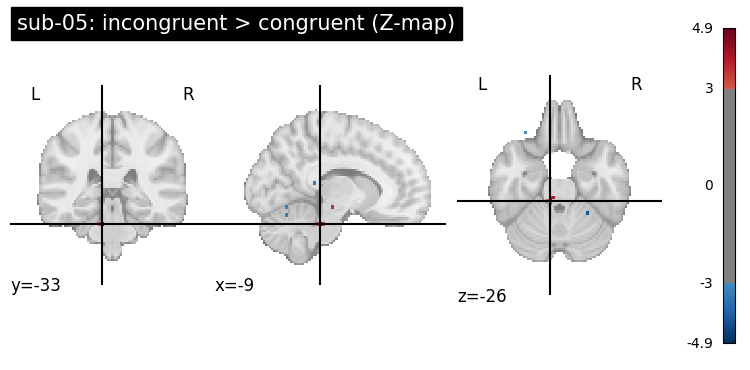

In [22]:
# Visualize one example Z-MAP
example_subject = "sub-05"

example_file = os.path.join(
    output_dir,
    f"{example_subject}_zmap_incongruent_vs_congruent.nii.gz"
)

z_map_example = image.load_img(example_file)

plotting.plot_stat_map(
    z_map_example,
    title=f"{example_subject}: incongruent > congruent (Z-map)",
    threshold=3.0
)
plotting.show()

### 8.2 Axial Slice View
Extract and display the central axial slice of the Z-map as a 2D matrix.

Z-map shape: (64, 64, 40)
Central slice index (z-axis): 20


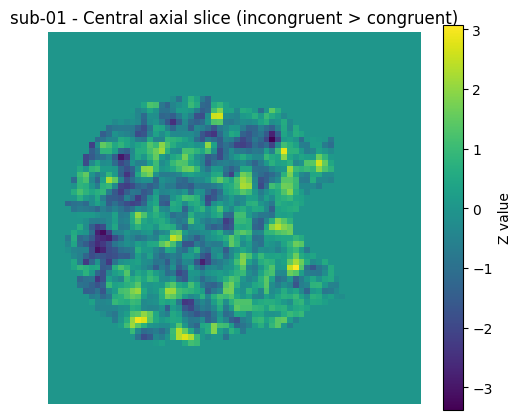

In [23]:
# Visualize central axial slice as 2D Matrix

import matplotlib.pyplot as plt
import numpy as np
from nilearn import image

# Choose one example subject
example_subject = "sub-01"

# Path to the subject's Z-map
example_file = os.path.join(
    output_dir,
    f"{example_subject}_zmap_incongruent_vs_congruent.nii.gz"
)

# Load the Z-map image
z_map_example = image.load_img(example_file)

# Get the 3D data array (x, y, z)
data = z_map_example.get_fdata()

# Compute the index of the central axial slice
# Axis 2 corresponds to the z-dimension (axial)
slice_idx = data.shape[2] // 2

# Extract the central axial slice
central_slice = data[:, :, slice_idx]

print("Z-map shape:", data.shape)
print("Central slice index (z-axis):", slice_idx)

# Plot the slice as a 2D matrix
plt.figure(figsize=(6, 5))
plt.imshow(central_slice, origin="lower")
plt.colorbar(label="Z value")
plt.title(f"{example_subject} - Central axial slice (incongruent > congruent)")
plt.axis("off")
plt.show()

### 8.3 Z-Value Distribution
Plot a histogram of the Z-values to analyze the distribution of statistical scores across the brain.

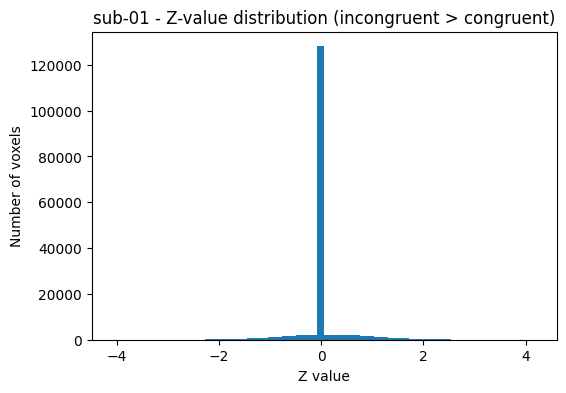

In [24]:
# Histogram of Z values

# Flatten the 3D array into 1D
z_values = data.flatten()

# Keep only finite values (avoid NaNs or infs)
z_values = z_values[np.isfinite(z_values)]

plt.figure(figsize=(6, 4))
plt.hist(z_values, bins=60)
plt.xlabel("Z value")
plt.ylabel("Number of voxels")
plt.title(f"{example_subject} - Z-value distribution (incongruent > congruent)")
plt.show()

/tmp/ipykernel_170931/2093849206.py:7: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_img = image.mean_img(img_path)


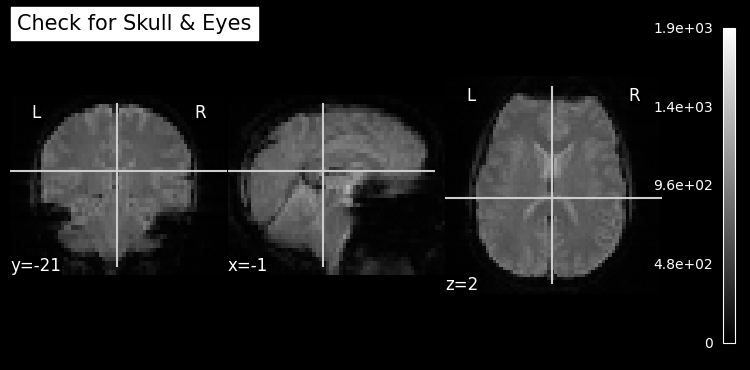

In [25]:
from nilearn import plotting, image
%matplotlib inline
# Load the first subject's first run
img_path = "data/ds101_R2.0.0/sub-04/func/sub-04_task-simon_run-1_bold.nii.gz"

# Compute the mean image (average over time)
mean_img = image.mean_img(img_path)

# Plot it
plotting.plot_anat(mean_img, title="Check for Skull & Eyes")
plotting.show()